In [46]:
import pandas as pd
import numpy as np
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from Transformer import *

# Import the utils from the Time2Vec Transformer
import sys
sys.path.append("../Time2Vec")
from utils import *

import warnings

warnings.filterwarnings('ignore')

weekly = pd.read_csv('../../../Dataset/Boulder_Weekly.csv')
weekly['Date'] = pd.to_datetime(weekly['Date'])
weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           239 non-null    datetime64[ns]
 1   Energy__kWh_   239 non-null    float64       
 2   Day            239 non-null    int64         
 3   Minimum T      239 non-null    int64         
 4   Maximum T      239 non-null    int64         
 5   Snow           239 non-null    float64       
 6   Precipitation  239 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 13.2 KB


In [47]:
# Sort the dataset accord to date, extract the mothns from the 'Date' column and drop it
if weekly['Date'].is_monotonic_increasing == False:
    weekly.sort_values(by='Date', ascending=True, inplace=True)

weekly['Month'] = weekly['Date'].dt.month_name()
weekly.drop(columns={'Date', 'Day'}, inplace=True)

    Scale the Dataset with MinMaxScaler / One-Hot Encode and Extract the Entire Scaled Dataset

In [48]:
# Define the columns we need to scale
columns_to_scale = ['Energy__kWh_', 'Minimum T', 'Maximum T', 'Snow', 'Precipitation']

# MinMax scaling for numerical columns
scaler = MinMaxScaler()
weekly_scaled = weekly.copy()
weekly_scaled[columns_to_scale] = scaler.fit_transform(weekly[columns_to_scale])

# Define the columns we need to use for One-Hot Encoding
categorical_columns = ['Month']

# One-hot encoding for 'Weekday' and 'Month'
onehot_encoder = OneHotEncoder(sparse=False)
categorical_encoded = onehot_encoder.fit_transform(weekly[categorical_columns])

# Get the feature names from the encoder
encoded_columns = []
for col, values in zip(categorical_columns, onehot_encoder.categories_):
    encoded_columns.extend([f'{col}_{value}' for value in values])

# Create DataFrame with encoded columns
categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=encoded_columns)

# Concatenate the new encoded columns to the original DataFrame
weekly_scaled = pd.concat([weekly_scaled, categorical_encoded_df], axis=1)

# Drop the original categorical columns
weekly_scaled = weekly_scaled.drop(categorical_columns, axis=1)
weekly_scaled.columns

Index(['Energy__kWh_', 'Minimum T', 'Maximum T', 'Snow', 'Precipitation',
       'Month_April', 'Month_August', 'Month_December', 'Month_February',
       'Month_January', 'Month_July', 'Month_June', 'Month_March', 'Month_May',
       'Month_November', 'Month_October', 'Month_September'],
      dtype='object')

    Divided the dataset into training, testing, and validation datasets according to 0.70, 0.20, and 0.10, respectively.

In [49]:
train_weekly_scaled, val_weekly_scaled, test_weekly_scaled = split_dataset(weekly_scaled, train_ratio=0.7, val_ratio=0.2)

Training split ratio:   0.699
Validation split ratio: 0.197
Testing split ratio:    0.105

Shapes of the datasets:
(167, 17) (47, 17) (25, 17)


    Create sequences for the Transformer model

In [50]:
sequence_length = 18
num_features = len(weekly_scaled.columns)

# Create the training, validation, and test data sequences
train_data_inputs, train_data_targets = create_sequences(train_weekly_scaled, sequence_length)
val_data_inputs, val_data_targets = create_sequences(val_weekly_scaled, sequence_length)
test_data_inputs, test_data_targets = create_sequences(test_weekly_scaled, sequence_length)

Dataset split into sequences:
Sequences shape: (149, 18, 17)
Targets shape: (149,)

Dataset split into sequences:
Sequences shape: (29, 18, 17)
Targets shape: (29,)

Dataset split into sequences:
Sequences shape: (7, 18, 17)
Targets shape: (7,)



    Create the Transformer Models

In [51]:
# Define the hyperparameters of the manual model
num_heads = 1
d_ff = 64
num_layers = 3
dropout_rate = 0.1
encoder_mask = None
decoder_mask = tf.linalg.band_part(tf.ones((sequence_length, sequence_length)), -1, 0)  # Create a lower triangular mask
decoder_mask = 1 - decoder_mask  # Invert the mask


if __name__ == "__main__":
   manual_model = main(sequence_length, num_features, num_heads, d_ff, num_layers, dropout_rate, encoder_mask, decoder_mask)


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 18, 17)]     0           []                               
                                                                                                  
 multi_head_attention_56 (Multi  (None, None, 17)    1224        ['input_7[0][0]',                
 HeadAttention)                                                   'input_7[0][0]',                
                                                                  'input_7[0][0]']                
                                                                                                  
 dropout_120 (Dropout)          (None, None, 17)     0           ['multi_head_attention_56[0][0]']
                                                                                            

In [52]:
# Create the transformer model
input_shape = (sequence_length, num_features)
keras_model = keras_transformer_model(input_shape, num_heads, d_ff, num_layers, dropout_rate)

keras_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 18, 17)]     0           []                               
                                                                                                  
 multi_head_attention_63 (Multi  (None, 18, 17)      1295        ['input_8[0][0]',                
 HeadAttention)                                                   'input_8[0][0]']                
                                                                                                  
 dropout_136 (Dropout)          (None, 18, 17)       0           ['multi_head_attention_63[0][0]']
                                                                                                  
 layer_normalization_105 (Layer  (None, 18, 17)      34          ['dropout_136[0][0]']      

    Compile the Models

In [53]:
# Define the learning rate for Adam optimizer
learning_rate = 0.01

# Compile the manual model
manual_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse',  metrics=['mae', 'mse', root_mean_squared_error])

# Compile the keras model
keras_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse',  metrics=['mae', 'mse', root_mean_squared_error])

    Train the Models

In [54]:
# Define the parameters for training
epochs = 200
batch_size = 512

# Convert the data to float32
train_data_inputs = train_data_inputs.astype('float32')
train_data_targets = train_data_targets.astype('float32')

val_data_inputs = val_data_inputs.astype('float32')
val_data_targets = val_data_targets.astype('float32')

train_data_inputs.shape, train_data_targets.shape, val_data_inputs.shape, val_data_targets.shape

((149, 18, 17), (149,), (29, 18, 17), (29,))

In [55]:
# Train the manual model
history_manual = manual_model.fit(train_data_inputs, train_data_targets,
          validation_data=(val_data_inputs, val_data_targets),
          epochs=epochs, batch_size=batch_size)

Epoch 1/200


1/1 [==============================] - 8s 8s/step - loss: 0.0848 - mae: 0.2600 - mse: 0.0848 - root_mean_squared_error: 0.2912 - val_loss: 0.2681 - val_mae: 0.5131 - val_mse: 0.2681 - val_root_mean_squared_error: 0.5178
Epoch 2/200
1/1 [==============================] - 0s 98ms/step - loss: 0.0768 - mae: 0.2448 - mse: 0.0768 - root_mean_squared_error: 0.2772 - val_loss: 0.2466 - val_mae: 0.4918 - val_mse: 0.2466 - val_root_mean_squared_error: 0.4966
Epoch 3/200
1/1 [==============================] - 0s 83ms/step - loss: 0.0672 - mae: 0.2265 - mse: 0.0672 - root_mean_squared_error: 0.2593 - val_loss: 0.2202 - val_mae: 0.4641 - val_mse: 0.2202 - val_root_mean_squared_error: 0.4692
Epoch 4/200
1/1 [==============================] - 0s 98ms/step - loss: 0.0561 - mae: 0.1989 - mse: 0.0561 - root_mean_squared_error: 0.2369 - val_loss: 0.1897 - val_mae: 0.4300 - val_mse: 0.1897 - val_root_mean_squared_error: 0.4355
Epoch 5/200
1/1 [==============================] - 0s 88ms/step - loss: 0.0433

In [56]:
# Train the keras model
history_keras = keras_model.fit(train_data_inputs, train_data_targets,
          validation_data=(val_data_inputs, val_data_targets),
          epochs=epochs, batch_size=batch_size)

Epoch 1/200
1/1 [==============================] - 14s 14s/step - loss: 0.0848 - mae: 0.2600 - mse: 0.0848 - root_mean_squared_error: 0.2912 - val_loss: 0.2697 - val_mae: 0.5147 - val_mse: 0.2697 - val_root_mean_squared_error: 0.5193
Epoch 2/200
1/1 [==============================] - 0s 177ms/step - loss: 0.0782 - mae: 0.2473 - mse: 0.0782 - root_mean_squared_error: 0.2796 - val_loss: 0.2518 - val_mae: 0.4970 - val_mse: 0.2518 - val_root_mean_squared_error: 0.5018
Epoch 3/200
1/1 [==============================] - 0s 164ms/step - loss: 0.0705 - mae: 0.2319 - mse: 0.0705 - root_mean_squared_error: 0.2655 - val_loss: 0.2281 - val_mae: 0.4725 - val_mse: 0.2281 - val_root_mean_squared_error: 0.4776
Epoch 4/200
1/1 [==============================] - 0s 357ms/step - loss: 0.0583 - mae: 0.2062 - mse: 0.0583 - root_mean_squared_error: 0.2415 - val_loss: 0.1999 - val_mae: 0.4417 - val_mse: 0.1999 - val_root_mean_squared_error: 0.4471
Epoch 5/200
1/1 [==============================] - 0s 206ms/s

    Evaluate the Models

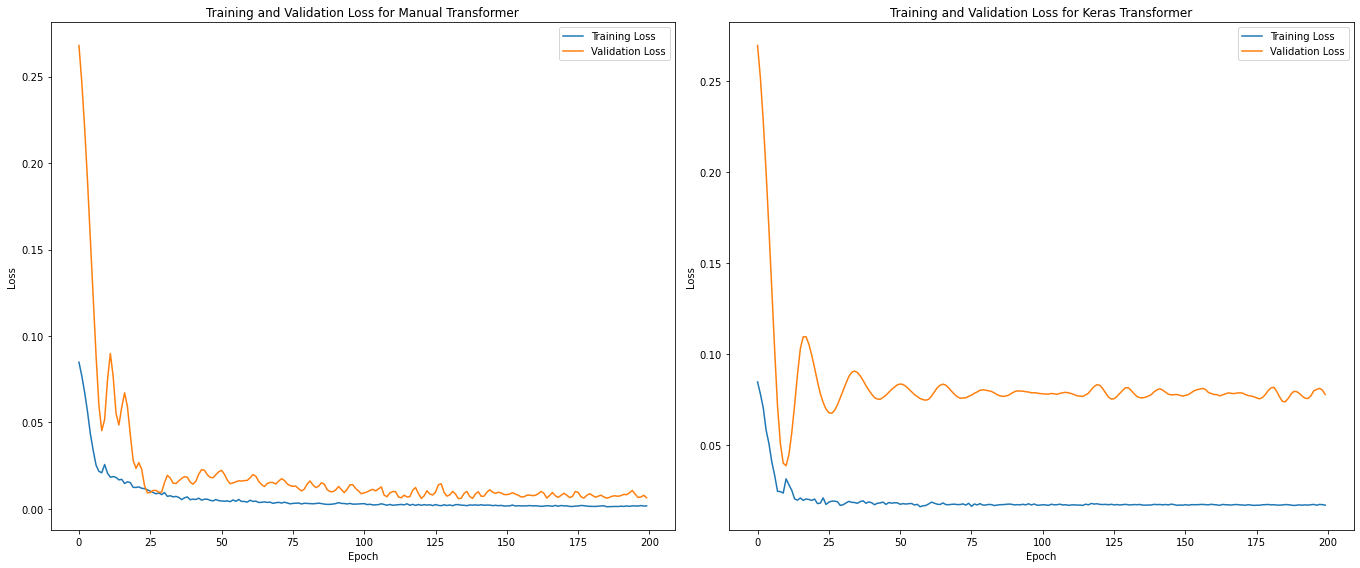

In [57]:
def plot_loss(history, model_name, ax):
    ax.plot(history.history['loss'], label='Training Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Validation Loss for ' + model_name)
    ax.legend()

fig, axes = plt.subplots(1, 2, figsize=(19, 8))

histories = [history_manual, history_keras]
model_names = ['Manual Transformer', 'Keras Transformer']

for history, model_name, ax in zip(histories, model_names, axes):
    plot_loss(history, model_name, ax)

plt.tight_layout()
plt.show()

In [58]:
# Evaluate on validation set
val_metrics_manual = manual_model.evaluate(val_data_inputs, val_data_targets, return_dict=True)
val_metrics_keras = keras_model.evaluate(val_data_inputs, val_data_targets, return_dict=True)

# Evaluate on test set
test_metrics_manual = manual_model.evaluate(test_data_inputs, test_data_targets, return_dict=True)
test_metrics_keras = keras_model.evaluate(test_data_inputs, test_data_targets, return_dict=True)

# Extract individual metrics
val_loss_manual, val_mae_manual, val_mse_manual, val_rmse_manual = val_metrics_manual['loss'], val_metrics_manual['mae'], val_metrics_manual['mse'], val_metrics_manual['root_mean_squared_error']
test_loss_manual, test_mae_manual, test_mse_manual, test_rmse_manual = test_metrics_manual['loss'], test_metrics_manual['mae'], test_metrics_manual['mse'], test_metrics_manual['root_mean_squared_error']

val_loss_keras, val_mae_keras, val_mse_keras, val_rmse_keras = val_metrics_keras['loss'], val_metrics_keras['mae'], val_metrics_keras['mse'], val_metrics_keras['root_mean_squared_error']
test_loss_keras, test_mae_keras, test_mse_keras, test_rmse_keras = test_metrics_keras['loss'], test_metrics_keras['mae'], test_metrics_keras['mse'], test_metrics_keras['root_mean_squared_error']

print('\n\nManual Transformer:\n-------------------')
print(f'Validation Loss: {val_loss_manual}, Validation MSE: {val_mse_manual}, Validation MAE: {val_mae_manual}, Validation RMSE: {val_rmse_manual}')
print(f'Test Loss: {test_loss_manual}, Test MSE: {test_mse_manual}, Test MAE: {test_mae_manual}, Test RMSE: {test_rmse_manual}')

print('\nKeras Transformer:\n------------------')
print(f'Validation Loss: {val_loss_keras}, Validation MSE: {val_mse_keras}, Validation MAE: {val_mae_keras}, Validation RMSE: {val_rmse_keras}')
print(f'Test Loss: {test_loss_keras}, Test MSE: {test_mse_keras}, Test MAE: {test_mae_keras}, Test RMSE: {test_rmse_keras}')


1/1 [==============================] - 0s 40ms/step - loss: 0.3760 - mae: 0.6085 - mse: 0.3760 - root_mean_squared_error: 0.6132


Manual Transformer:
-------------------
Validation Loss: 0.006341175176203251, Validation MSE: 0.006341175176203251, Validation MAE: 0.06263889372348785, Validation RMSE: 0.0796314999461174
Test Loss: 0.1802843064069748, Test MSE: 0.1802843064069748, Test MAE: 0.41124460101127625, Test RMSE: 0.4245989918708801

Keras Transformer:
------------------
Validation Loss: 0.07791902124881744, Validation MSE: 0.07791902124881744, Validation MAE: 0.27042001485824585, Validation RMSE: 0.27913978695869446
Test Loss: 0.3759670555591583, Test MSE: 0.3759670555591583, Test MAE: 0.6084648966789246, Test RMSE: 0.6131615042686462


In [59]:
# Assuming manual_model.predict returns the predictions
val_predictions_manual = manual_model.predict(val_data_inputs)
test_predictions_manual = manual_model.predict(test_data_inputs)

# Assuming keras_model.predict returns the predictions
val_predictions_keras = keras_model.predict(val_data_inputs)
test_predictions_keras  = keras_model.predict(test_data_inputs)

# Calculate MAE and RMSE for validation set
val_mae_manual = np.mean(np.abs(val_data_targets - val_predictions_manual))
val_rmse_manual = np.sqrt(np.mean(np.square(val_data_targets - val_predictions_manual)))

val_mae_keras  = np.mean(np.abs(val_data_targets - val_predictions_keras ))
val_rmse_keras  = np.sqrt(np.mean(np.square(val_data_targets - val_predictions_keras )))

# Calculate MAE and RMSE for test set
test_mae_manual = np.mean(np.abs(test_data_targets - test_predictions_manual))
test_rmse_manual = np.sqrt(np.mean(np.square(test_data_targets - test_predictions_manual)))

test_mae_keras  = np.mean(np.abs(test_data_targets - test_predictions_keras ))
test_rmse_keras  = np.sqrt(np.mean(np.square(test_data_targets - test_predictions_keras )))


print('\n\nManual Transformer:\n-------------------')
print(f'Validation MAE: {val_mae_manual}')
print(f'Validation RMSE: {val_rmse_manual}')
print(f'\nTest MAE: {test_mae_manual}')
print(f'Test RMSE: {test_rmse_manual}')
print('\n==============================')
print('\nKeras Transformer:\n------------------')
print(f'Validation MAE: {val_mae_keras }')
print(f'Validation RMSE: {val_rmse_keras }')
print(f'\nTest MAE: {test_mae_keras }')
print(f'Test RMSE: {test_rmse_keras }')

1/1 [==============================] - 0s 40ms/step


Manual Transformer:
-------------------
Validation MAE: 0.07047449797391891
Validation RMSE: 0.0884234681725502

Test MAE: 0.4112445881951989
Test RMSE: 0.4202875239154641


Keras Transformer:
------------------
Validation MAE: 0.27041998505592346
Validation RMSE: 0.27913978695869446

Test MAE: 0.6084649051502203
Test RMSE: 0.6131615307704102


In [60]:
def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def evaluate_predictions_model(model, model_name, train_data_inputs, train_data_targets, val_data_inputs, val_data_targets, test_data_inputs, test_data_targets, scaler):
    # Predictions on training data
    y_pred_train = model.predict(train_data_inputs)
    inversed_y_pred_train = scaler.inverse_transform(np.concatenate([y_pred_train, np.zeros((y_pred_train.shape[0], scaler.n_features_in_-1))], axis=1))
    inversed_y_pred_train = inversed_y_pred_train[:, 0]

    # Inverse the target train data
    train_targets_scaled_data = train_data_targets.reshape(-1,1)
    train_targets_data = scaler.inverse_transform(np.concatenate([train_targets_scaled_data, np.zeros((train_targets_scaled_data.shape[0], scaler.n_features_in_-1))], axis=1))
    train_targets_data = train_targets_data[:, 0]

    # Metrics on training data
    train_rmse = calculate_rmse(train_targets_data, inversed_y_pred_train)
    train_mae = calculate_mae(train_targets_data, inversed_y_pred_train)

    # Predictions on validation data
    y_pred_val = model.predict(val_data_inputs)
    inversed_y_pred_val = scaler.inverse_transform(np.concatenate([y_pred_val, np.zeros((y_pred_val.shape[0], scaler.n_features_in_-1))], axis=1))
    inversed_y_pred_val = inversed_y_pred_val[:, 0]
    
    # Inverse the target validation data
    val_targets_scaled_data = val_data_targets.reshape(-1,1)
    val_targets_data = scaler.inverse_transform(np.concatenate([val_targets_scaled_data, np.zeros((val_targets_scaled_data.shape[0], scaler.n_features_in_-1))], axis=1))
    val_targets_data = val_targets_data[:, 0]

    # Metrics on validation data
    val_rmse = calculate_rmse(val_targets_data, inversed_y_pred_val)
    val_mae = calculate_mae(val_targets_data, inversed_y_pred_val)

    # Predictions on test data
    y_pred_test = model.predict(test_data_inputs)
    inversed_y_pred_test = scaler.inverse_transform(np.concatenate([y_pred_test, np.zeros((y_pred_test.shape[0], scaler.n_features_in_-1))], axis=1))
    inversed_y_pred_test = inversed_y_pred_test[:, 0]

    test_targets_scaled_data = test_data_targets.reshape(-1,1)
    test_targets_data = scaler.inverse_transform(np.concatenate([test_targets_scaled_data, np.zeros((test_targets_scaled_data.shape[0], scaler.n_features_in_-1))], axis=1))
    test_targets_data = test_targets_data[:, 0]

    # Metrics on test data
    test_rmse = calculate_rmse(test_targets_data, inversed_y_pred_test)
    test_mae = calculate_mae(test_targets_data, inversed_y_pred_test)
    
    # Print the results
    print(f"\n\nEvaluation metrics for {model_name} model:\n-------------------")
    print('Train Dataset:')
    print(f"RMSE: {train_rmse}")
    print(f"MAE: {train_mae}\n-------------------")

    print('Validation Dataset:')
    print(f"RMSE: {val_rmse}")
    print(f"Validation MAE: {val_mae}\n-------------------")
    
    print('Test Dataset:')
    print(f"Test RMSE: {test_rmse}")
    print(f"Test MAE: {test_mae}\n\n")

evaluate_predictions_model(manual_model, model_name, train_data_inputs, train_data_targets, val_data_inputs, val_data_targets, test_data_inputs, test_data_targets, scaler)
evaluate_predictions_model(keras_model, model_name, train_data_inputs, train_data_targets, val_data_inputs, val_data_targets, test_data_inputs, test_data_targets, scaler)

1/1 [==============================] - 0s 48ms/step


Evaluation metrics for Keras Transformer model:
-------------------
Train Dataset:
RMSE: 130.40876924309197
MAE: 101.88476235247882
-------------------
Validation Dataset:
RMSE: 314.7856732234422
Validation MAE: 247.61339965018732
-------------------
Test Dataset:
Test RMSE: 1678.4525914680878
Test MAE: 1625.6621944732667


1/1 [==============================] - 0s 34ms/step


Evaluation metrics for Keras Transformer model:
-------------------
Train Dataset:
RMSE: 518.6019838163944
MAE: 451.4432205732321
-------------------
Validation Dataset:
RMSE: 1103.4478935040145
Validation MAE: 1068.9783338375955
-------------------
Test Dataset:
Test RMSE: 2423.845931470756
Test MAE: 2405.2800240059746


